# Results Visualization for Eval Models

In [1]:
import pandas as pd
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import re

Populating the interactive namespace from numpy and matplotlib


Import the data from file. index_col=False is required to keep the trailing \t from being interpreted as an extra column.

In [2]:
raw = pd.read_csv('result_log.txt', sep='\t', index_col=False).set_index('ID')
print('%i rows; %i columns' % raw.shape)

26 rows; 65 columns


Names of the printers to display on the plot, based on their printer number

In [80]:
printer_names = {0:'DLP %s', 1:'1%s.Color Changing', 2:'2%s.Gold', 3:'3%s.Green', 4:'4%s.No Fan, Blue', 
                 5:'5%s.Teal', 6:'6%s.Glow', 7:'7%s.Teal', 8:'8%s.PLA+ Black', 9:'9%s.Cube White'}

abnormal_printers = [printer_names[0] % 'a', printer_names[4] % 'a', printer_names[4] % 'b']

Get rid of a few entries which are left from testing the server, and keep the later of two entries with the same group name.

In [4]:
data = raw[raw['Printer Model'].str.contains(r'Test').isin([False])].copy()
data.drop_duplicates(subset='Group Name', keep='last', inplace=True)
print('Removed %i rows' % (raw.shape[0] - data.shape[0]))
print('Now dataset contains %i rows' % data.shape[0])

Removed 7 rows
Now dataset contains 19 rows


Add a column which contains the numeric printer number, and use this to sort the data

In [5]:
def get_number(mystr):
    out = re.findall('[0-9]+', mystr)
    if len(out) > 0:
        return int(out[-1])
    else:
        return 0
data.insert(0, 'Printer ID', map(get_number, data['Printer Name'].tolist()))

_NOTE_ Now do some manual data mangling to deal with user errors...

In [6]:
#data.at[22,'Printer ID'] = 4

Sort the data based on printer ID

In [7]:
data = data.sort_values(by="Printer ID")

The column headers follow a pattern, of the form \[Field Name\] \[Yellow|Red\] \[Minimum|Error\]. Use some could-be-improved Python to generate the list from the column labels.

In [8]:
color_list = ['Yellow', 'Red']
type_list = ['Minimum', 'Error']

first_datacol = np.where(data.columns.values == 'Feedback')[0][0] + 1
col_titles = data.columns[first_datacol:].tolist()
col_titles = map(lambda a:' '.join(a.split(' ')[0:-2]), col_titles)
fields = []
# remove duplicates...
for col in col_titles:
    if col not in fields:
        fields.append(col)

Reorder the list a bit... We'll put horizontal and vertical things together, and fillets at the ends.

In [9]:
fields = list( fields[i] for i in [6,1,7,3,2,4, 13,5, 0,12,10,11,9,8] )
fields

['Horizontal Circular Bars',
 'Horizontal Circular Holes',
 'Horizontal Fins',
 'Horizontal Slots',
 'Horizontal Bosses',
 'Horizontal Pockets',
 'Inter-Layer Fillets',
 'In-Layer Fillets',
 'Vertical Pillars',
 'Vertical Circular Holes',
 'Vertical Fins',
 'Vertical Slots',
 'Vertical Bosses',
 'Vertical Pockets']

Convert the data table into a set of tables for plotting, each containing a relevant chunk of the rows for every column.

In [76]:

def get_printer_names():
    """Creates a unique printer name from the (non-unique) printer IDs"""
    printer_counts = [0] * len(printer_names)
    names = []
    for printer_id in data['Printer ID'].tolist():
        names.append(printer_names[printer_id] % chr(ord('a') + printer_counts[printer_id]))
        printer_counts[printer_id] += 1
    return names

def get_data(color_name, type_name):
    some_data = data.T.loc[map(lambda a:'%s %s %s' % (a, color_name, type_name), fields)].copy()
    some_data.index = fields
    some_data.columns = get_printer_names()
    some_data = some_data.applymap(lambda x: np.nan if x == 'None' else float(x))
    return some_data

yellow_mins = get_data(color_list[0], type_list[0])
yellow_errs = get_data(color_list[0], type_list[1])
red_mins = get_data(color_list[1], type_list[0])
red_errs = get_data(color_list[1], type_list[1])

feature_count = yellow_mins.shape[0]
run_count = yellow_mins.shape[1]

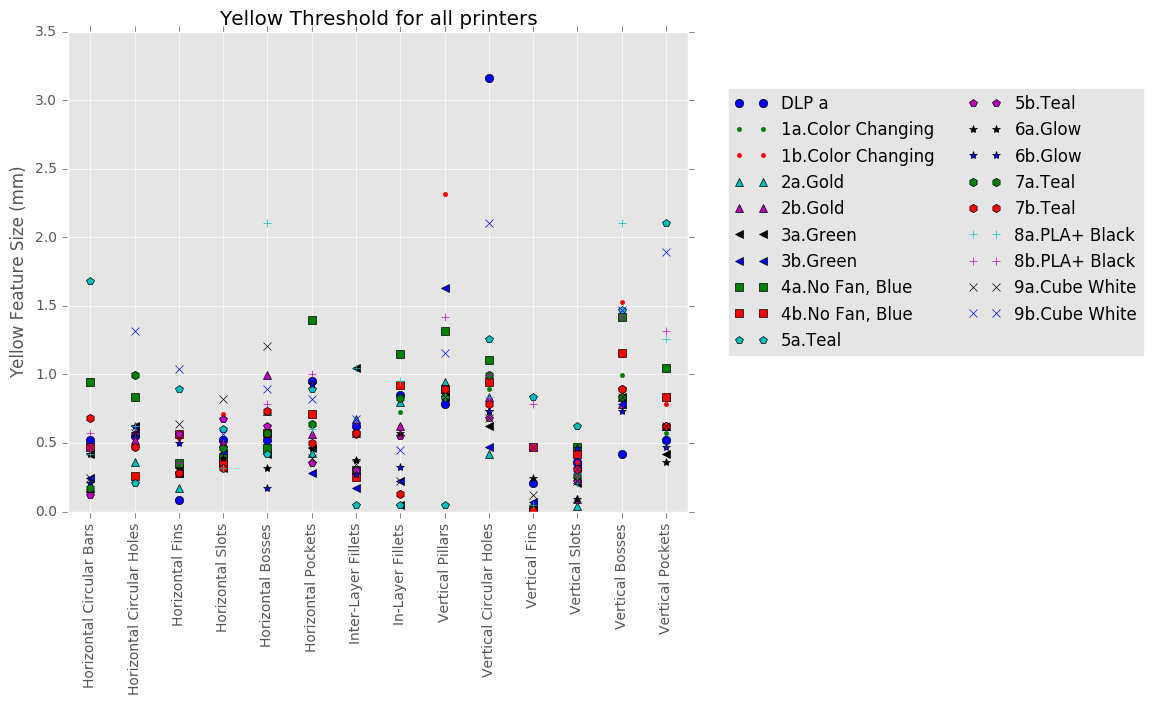

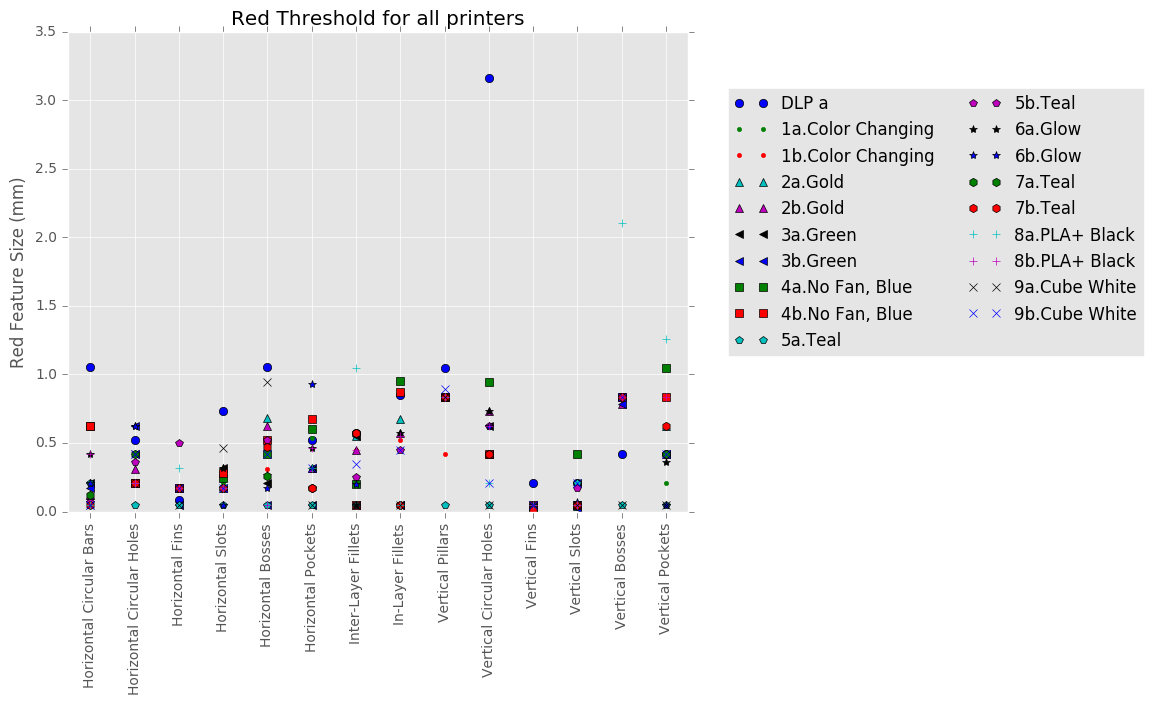

In [78]:
fig = plt.figure();
ax = fig.add_subplot(111)
plt.xticks(np.arange(feature_count))
plt.ylabel('%s Feature Size (mm)' % color_list[0])

plot_markers = ['o', '.', '^', '<', 's', 'p', '*', 'h', '+', 'x', 'D']
plot_colors = ['b', 'g', 'r', 'c', 'm', 'k']

plt.hold(True)

for i in range(run_count):
    yellow_mins.iloc[:,i].plot(marker=plot_markers[int(((i+1)/2))], color=plot_colors[i % len(plot_colors)], linestyle='None')


plt.xlim([-0.5, feature_count-0.5])
ax.set_xticklabels(ax.xaxis.get_majorticklabels(),rotation=90)
plt.legend(ncol=2, loc='upper left', bbox_to_anchor=(1.05,0.9))
plt.title('Yellow Threshold for all printers')
plt.hold(False)
plt.show()

fig = plt.figure();
ax = fig.add_subplot(111)
plt.xticks(np.arange(feature_count))
plt.ylabel('%s Feature Size (mm)' % color_list[0])

plot_markers = ['o', '.', '^', '<', 's', 'p', '*', 'h', '+', 'x', 'D']
plot_colors = ['b', 'g', 'r', 'c', 'm', 'k']

plt.hold(True)

for i in range(run_count):
    red_mins.iloc[:,i].plot(marker=plot_markers[int(((i+1)/2))], color=plot_colors[i % len(plot_colors)], linestyle='None')


plt.xlim([-0.5, feature_count-0.5])
ax.set_xticklabels(ax.xaxis.get_majorticklabels(),rotation=90)
plt.legend(ncol=2, loc='upper left', bbox_to_anchor=(1.05,0.9))
plt.title('Red Threshold for all printers')
plt.ylabel('%s Feature Size (mm)' % color_list[1])
plt.hold(False)
plt.show()

Plot statistics for "normal" printers, excluding number 0 (DLP), number 4 (no fan)

In [81]:
yellow_normal_data = yellow_mins.T.copy()
yellow_normal_data = yellow_normal_data.drop(abnormal_printers)
red_normal_data = red_mins.T.copy()
red_normal_data = red_normal_data.drop(abnormal_printers)

yellow_special_data = yellow_mins.T.copy()
yellow_special_data = yellow_special_data.loc[abnormal_printers]
red_special_data = red_mins.T.copy()
red_special_data = red_special_data.loc[abnormal_printers]
yellow_special_data.iloc[1].name

'4a.No Fan, Blue'

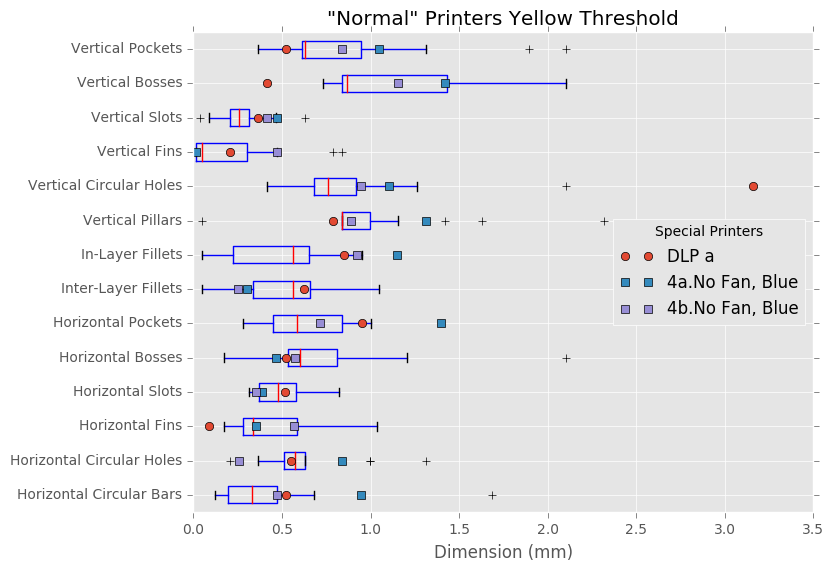

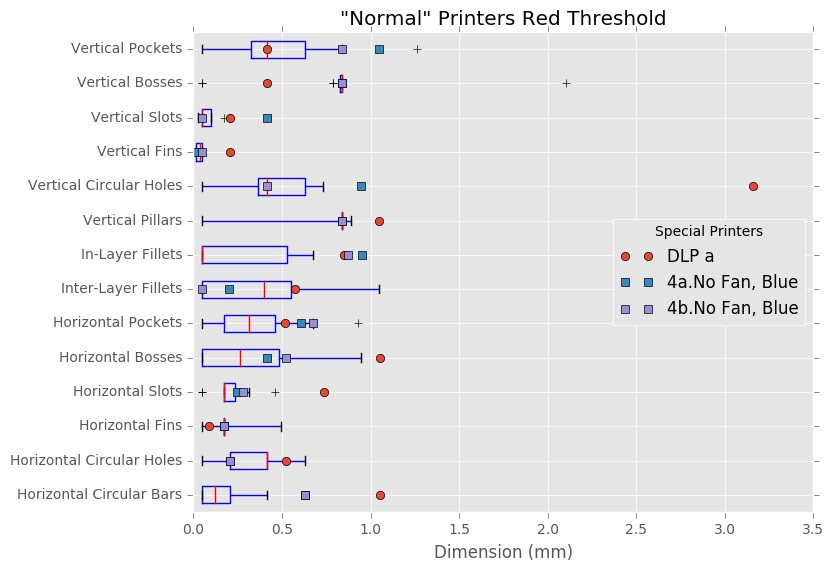

In [82]:
plt.rcdefaults()
matplotlib.style.use('ggplot')
#%matplotlib notebook # Make the plots interactive
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(yellow_normal_data.values.astype(np.float32), widths=0.5, showbox=True, showmeans=False, vert=False, 
           whiskerprops=dict(linestyle='-'))
ax.hold(True)
# Plot the special printers
shapes=['o', 's', 's']
for i in range(yellow_special_data.shape[0]):
    ax.plot(yellow_special_data.iloc[i].values.astype(np.float32), range(1, yellow_special_data.shape[1] + 1), shapes[i],
            label=yellow_special_data.iloc[i].name)
ax.set_yticklabels(fields)
plt.title('"Normal" Printers Yellow Threshold')
plt.xlabel('Dimension (mm)')
plt.legend(loc='right', title='Special Printers')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(red_normal_data.values.astype(np.float32), widths=0.5, showbox=True, showmeans=False, vert=False, 
           whiskerprops=dict(linestyle='-'))
ax.hold(True)
# Plot the special printers
shapes=['o', 's', 's']
for i in range(red_special_data.shape[0]):
    ax.plot(red_special_data.iloc[i].values.astype(np.float32), range(1, red_special_data.shape[1] + 1), shapes[i],
            label=red_special_data.iloc[i].name)
plt.legend(loc='right', title='Special Printers')
ax.set_yticklabels(fields)
plt.title('"Normal" Printers Red Threshold')
plt.xlabel('Dimension (mm)')
plt.show()

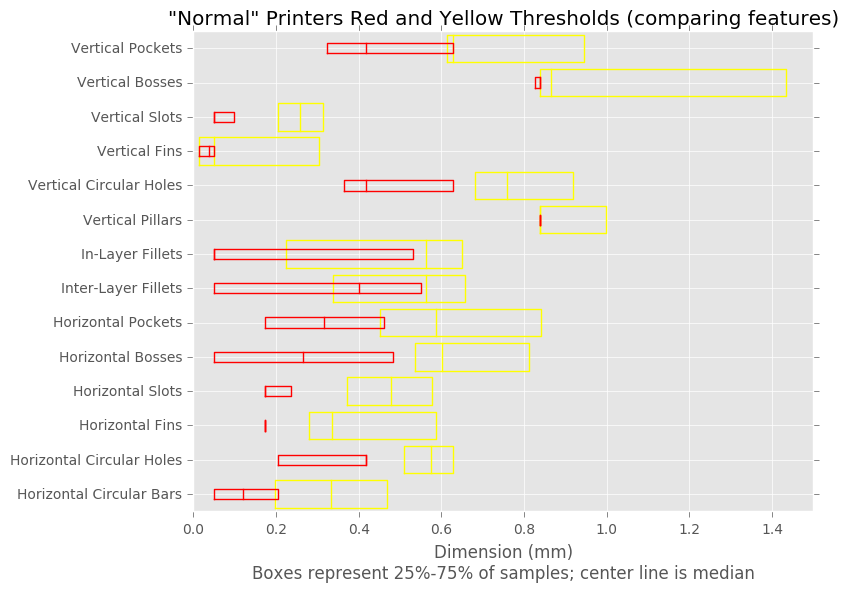

In [83]:
plt.rcdefaults()
matplotlib.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(yellow_normal_data.values.astype(np.float32), widths=0.8, boxprops=dict(color='yellow'), 
           whiskerprops=dict(linestyle=''), medianprops=dict(color='yellow'), meanprops=dict(markerfacecolor='yellow'), 
           showbox=True, showcaps=False, showfliers=False, showmeans=False, vert=False)
ax.hold(True)
ax.boxplot(red_normal_data.values.astype(np.float32), widths=0.3, boxprops=dict(color='red'), 
           whiskerprops=dict(linestyle=''), medianprops=dict(color='red'), meanprops=dict(markerfacecolor='red'), 
           showbox=True, showcaps=False, showfliers=False, showmeans=False, vert=False)
#yellow_special_data.T.plot.scatter()
#ax.set_yticklabels(fields)
plt.xlim([0, 1.5])
plt.title('"Normal" Printers Red and Yellow Thresholds (comparing features)')
ax.set_yticklabels(fields)
plt.xlabel('Dimension (mm)\nBoxes represent 25%-75% of samples; center line is median')
plt.show()

Looked at with a different column ordering which emphasizes the horizontal/vertical differences

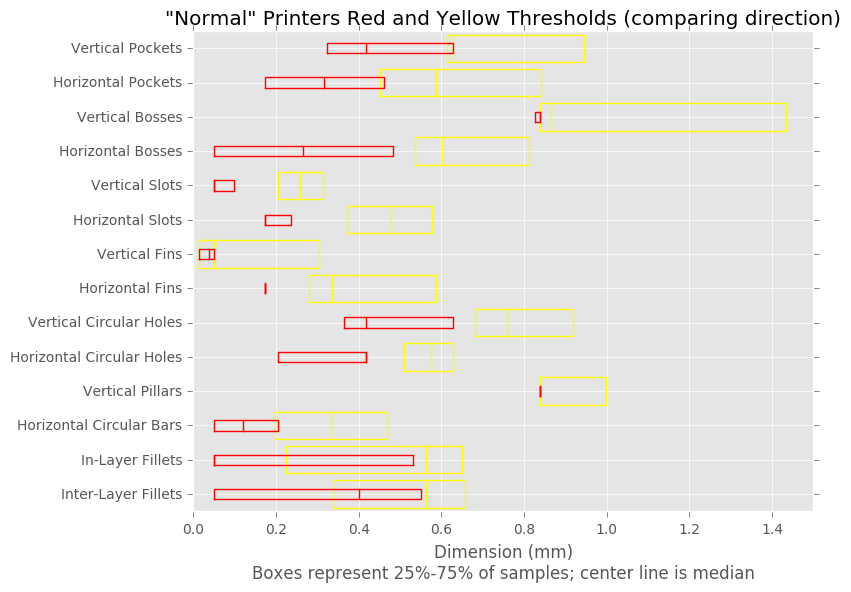

In [84]:
fieldmap = [6,7, 0,8, 1,9, 2,10, 3,11, 4,12, 5,13]

plt.rcdefaults()
matplotlib.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.boxplot(yellow_normal_data.iloc[:,fieldmap].values.astype(np.float32), widths=0.8, boxprops=dict(color='yellow'), 
           whiskerprops=dict(linestyle=''), medianprops=dict(color='yellow'), meanprops=dict(markerfacecolor='yellow'), 
           showbox=True, showcaps=False, showfliers=False, showmeans=False, vert=False)
ax.hold(True)
ax.boxplot(red_normal_data.iloc[:,fieldmap].values.astype(np.float32), widths=0.3, boxprops=dict(color='red'), 
           whiskerprops=dict(linestyle=''), medianprops=dict(color='red'), meanprops=dict(markerfacecolor='red'), 
           showbox=True, showcaps=False, showfliers=False, showmeans=False, vert=False)
#yellow_special_data.T.plot.scatter()
#ax.set_yticklabels(fields)
plt.xlim([0, 1.5])
plt.title('"Normal" Printers Red and Yellow Thresholds (comparing direction)')
ax.set_yticklabels(list( fields[i] for i in fieldmap ))
plt.xlabel('Dimension (mm)\nBoxes represent 25%-75% of samples; center line is median')
plt.show()

## Statistics for each test
Let's compile some agregate statistics for each qualification run. In particular we'll compute
* Sum of deviation from the median for each feature
* Root-Sum-Square of deviation from the mean for each feature
* Average of the error reported from the qualification process (indication of whether the test was run twice or only once)

It was hard to find the docs for this functionality. The best link was [here](http://pandas.pydata.org/pandas-docs/stable/style.html)

In [110]:
# I want to tweak the .bar styler builtin to handle negative numbers better. The following is pulled from the pandas github.
from pandas.core.indexing import _maybe_numeric_slice, _non_reducing_slice

def _bar(s, colorpos, colorneg, width):
    normed = width * (s.abs() - max(0, s.min())) / (s.max() - max(0, s.min()))

    base = 'width: 10em; height: 80%;'
    attrs = (base + 'background: linear-gradient(90deg,{c} {w}%, '
                    'transparent 0%)')
    return [attrs.format(c=colorpos if s.iloc[i] > 0 else colorneg, w=normed.iloc[i]) if normed.iloc[i] != 0 else base for i in range(len(normed))]

def bar(styler, subset=None, axis=0, colorpos='#d65f5f', colorneg='#f65353', width=100):
    subset = _maybe_numeric_slice(styler.data, subset)
    subset = _non_reducing_slice(subset)
    styler.apply(_bar, subset=subset, axis=axis, colorpos=colorpos, colorneg=colorneg,
               width=width)
    return styler

In [125]:
def get_stats(dataset, normal_dataset, errorset):
    medians = normal_dataset.median(axis=1)
    diffs = dataset.T - medians
    diffsum = diffs.sum(axis=1)
    diffrms = diffs.T.pow(2).sum().pow(0.5)
    errormean = errorset.mean(numeric_only=True, skipna=True)
    out = pd.DataFrame()
    out['RSS Deviation from Normal Median'] = diffrms
    out['Total Deviation from Normal Median'] = diffsum
    out['Mean reported error'] = errormean
    return out
    

stats = get_stats(yellow_mins, yellow_normal_data.T, yellow_errs)
stats = stats.sort_values(by="RSS Deviation from Normal Median", ascending=False)
bar(stats.style.set_precision(3), colorpos='#6693ef', width=95).set_caption('Yellow Threshold Deviation Data')

In [126]:
rstats = get_stats(red_mins, red_normal_data.T, red_errs)
rstats = rstats.sort_values(by="RSS Deviation from Normal Median", ascending=False)
bar(rstats.style.set_precision(3), colorpos='#6693ef', width=95).set_caption('Red Threshold Deviation Data')